# Product Demand Forecasting

### Import Modules

In [1]:
from __future__  import print_function, division
import datetime
import pandas as pd
import numpy as np
import requests
#import cpi
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy
import copy
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

Recall that the original Columns are:

Product_Code - The product name encoded  
Warehouse - Warehouse name encoded  
Product_Category - Product Category for each Product_Code encoded  
Date - The date **customer** needs the product  
**Order_Demand - single order qty**  

### Import Data 

In [2]:
# Open the pickled cleaned, transformed data
#remember that with is a "messenger" per se

with open('cleaned_product_data.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

### Inspect Data Characteristics

In [3]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()
#There is data for 6 years. great.

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [4]:
#Make copy of dataframe to preserve the orginal
data = df.copy()
data.head(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Week,DoM,DoW
0,0993,J,028,2012-07-27,100,2012.0,7.0,30.0,27.0,4.0


In [5]:
# we are most interested in `Date` column that contains date of sales; 
data.set_index('Date', inplace=True)

# # sort dates to ascending and view
data.sort_index(inplace=True)

In [6]:
data.head(1)

,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,Week,DoM,DoW
Date,,,,,,,,,
2011-01-08,0965,A,006,2,2011.0,1.0,1.0,8.0,5.0


### Analysis with Product Category 19 
#### Recall that Product Category 19 accounted for 83% of total Order Demand


#### Create a continuous list of dates for data date range

In [7]:
#Create a df of ALL DATES between the earliest and latest dates in the data
df_all_dates = pd.DataFrame(pd.date_range(start = '2011-01-08', end = '2017-01-09'))
df_all_dates.head(2)

,0
0,2011-01-08
1,2011-01-09


In [8]:
#Rename the column from 0 to exact same as column in the data set
df_all_dates = df_all_dates.rename({0:'Date'}, axis = 1)
df_all_dates.head(2)

,Date
0,2011-01-08
1,2011-01-09


In [9]:
#Create a separate df for Category 019 data
df_0019 = data[data.Product_Category == '019']
#df_0019.head(20)

In [10]:
#Merge Category 19 with all_dates to make one df with full dates
df_0019 = df_0019.merge(df_all_dates, on = 'Date', how = 'right').\
                    sort_values("Date").reset_index(drop = True)

In [11]:
df_0019.sort_values(by = 'Date')

,Date,Product_Code,Warehouse,Product_Category,Order_Demand,Year,Month,Week,DoM,DoW
0,2011-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
470849,2017-01-06,1316,J,019,10000.0,2017.0,1.0,1.0,6.0,4.0
470850,2017-01-06,1316,J,019,10000.0,2017.0,1.0,1.0,6.0,4.0
470851,2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
470852,2017-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Remove NaNs from Order_Demand
df_0019['Order_Demand'] = df_0019['Order_Demand'].fillna(0)

In [13]:
#Need one data point for each day so groupby day and sum
#Note that since Order_Demand is the only numeric value this yields two columns
df_0019= df_0019.reset_index().groupby('Date')['Order_Demand'].agg(sum)

In [14]:
#Make dataframe of Date and Order Demand
df_0019 = pd.DataFrame(df_0019)

### Subset data by date
Remove 2011 as too many missing values.  
Subset 2016 and later as that will be test data

In [15]:
df_0019_train = df_0019[(df_0019.index >'2012-01-01') & (df_0019.index<'2016-01-01')]

In [16]:
df_0019_test = df_0019[(df_0019.index > '2015-12-31')]
df_0019_test.shape

(375, 1)

### Resample the data by week

In [17]:
#resample by week
df_0019_weekly = df_0019_train.resample('W').sum()

In [18]:
len(df_0019_weekly)

209

### Visualize data by day, week

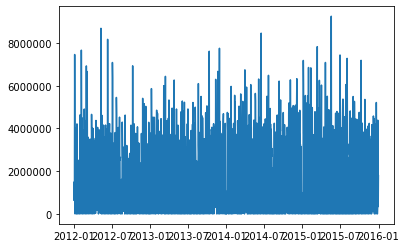

In [19]:
#Recall that df_0019 is daily orders
plt.plot(df_0019_train['Order_Demand'])

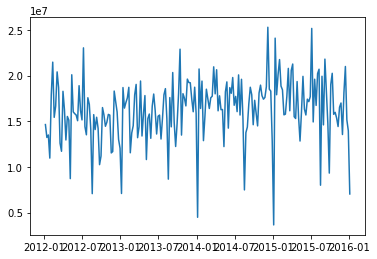

In [20]:
plt.plot(df_0019_weekly)

### Series decomposition - weekly

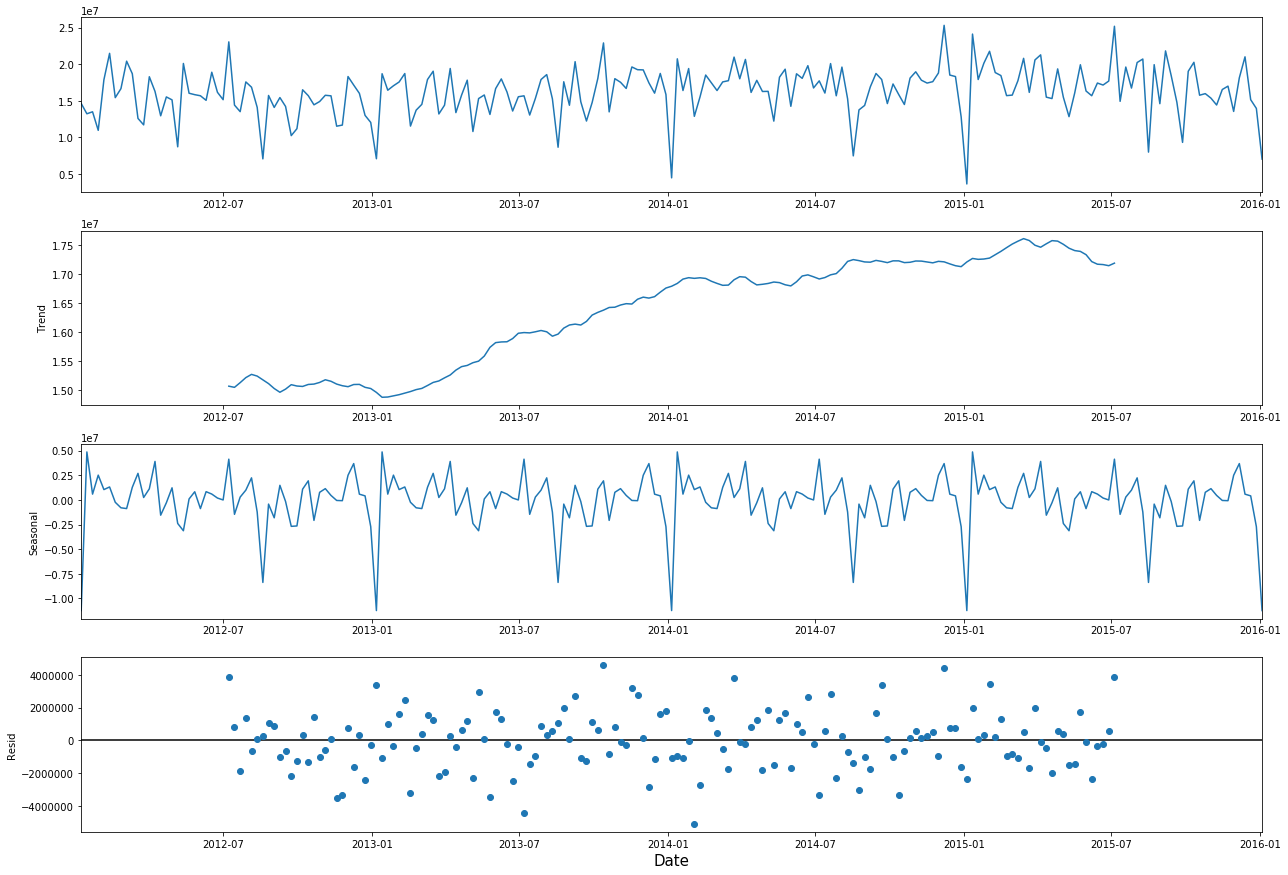

In [21]:
#Averages daily sales value for the month, and we are using the start of each month 
#as the timestamp.
#y = df_0019_weekly['Order_Demand'].resample('W').mean()

#resample by week
y =  df_0019_train.resample('W').sum()

#The best part about time series data and decomposition is that you can break down 
#the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 12
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
#fig.suptitle('Series Decomposition', fontsize = 15 )
plt.xlabel('Date', fontsize = 15)
plt.show()
fig.savefig('ProdCat019SeriesDecomp.jpg')

In [22]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

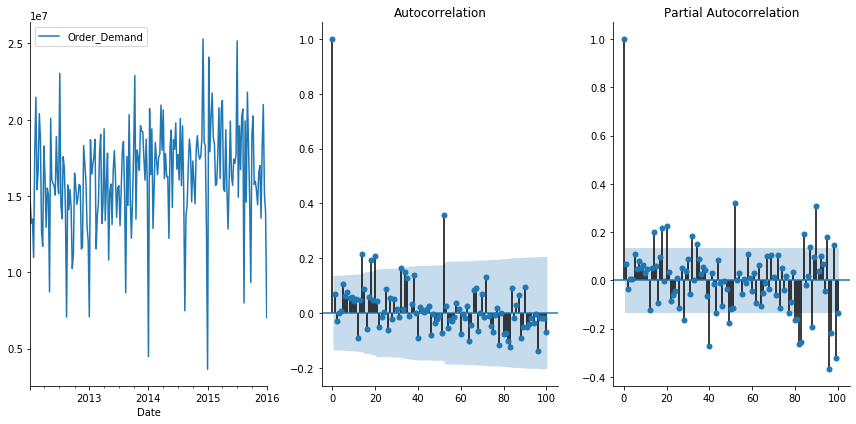

In [23]:
plots(df_0019_weekly, lags = 100)

## Modeling

#### Product Category 019 Model Testing

In [24]:
mod = sm.tsa.statespace.SARIMAX(np.log(df_0019_weekly+1), 
                                trend='n', order=(0,1,1),
                                seasonal_order = (1,0,0, 52),
                                enforce_stationarity = True)
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Order_Demand   No. Observations:                  209
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                  31.119
Date:                             Tue, 24 Mar 2020   AIC                            -56.237
Time:                                     11:58:19   BIC                            -46.225
Sample:                                 01-08-2012   HQIC                           -52.189
                                      - 01-03-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9723      0.015    -65.746      0.000      -1.001      -0.943
ar.S.L52       0.6218      0.042     14.631      0.000       0.539       0.705
sigma2         0.0379      0.003     11.166      0.000       0.031       0.045
===================================================================================
Ljung-Box (Q):                       30.85   Jarque-Bera (JB):                87.71
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.91
Prob(H) (two-sided):                  0.78   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

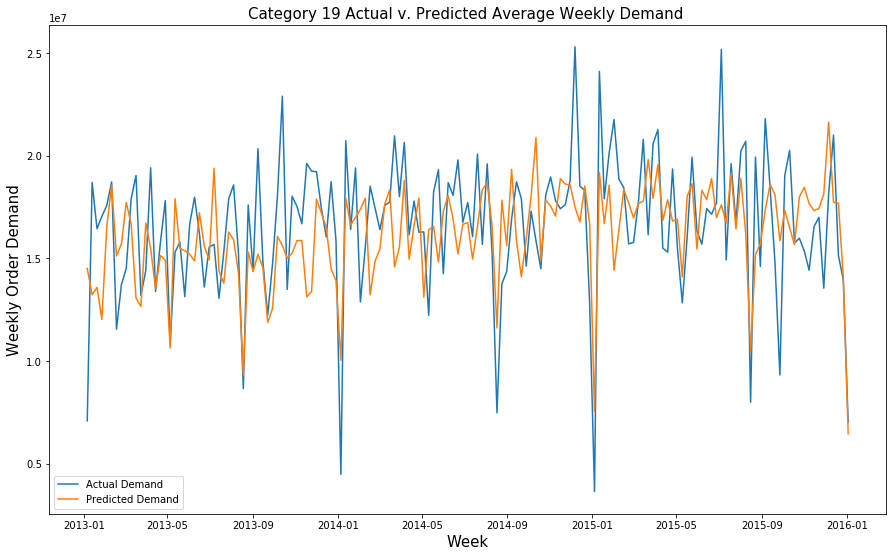

In [25]:
#Blue - actual and Yellow = predicted
y_pred = res.get_prediction()
y_pred.predicted_mean
#plt.plot(np.log(df_0019_weekly['Order_Demand'].iloc[train_index]+1))
fig = plt.figure(figsize  = (15,9))
#plt.plot(df_0019_weekly['Order_Demand'].iloc[train_index])
plt.plot(df_0019_weekly['Order_Demand'][52:], label= 'Actual Demand')#.iloc[train_index])
plt.plot(np.exp(y_pred.predicted_mean)[52:], label= 'Predicted Demand')
plt.title('Category 19 Actual v. Predicted Average Weekly Demand ', fontsize = 15)
plt.ylabel('Weekly Order Demand', fontsize = 15)
plt.xlabel('Week', fontsize = 15)
plt.legend(loc = 'lower left')
plt.show()
fig.savefig('ProdCat019ActvPredWeekAvg.jpg')

In [26]:
train_index = df_0019_weekly.index

In [27]:
actual = df_0019_weekly['Order_Demand'].loc[train_index]
predicted =np.exp(y_pred.predicted_mean[:actual.shape[0]])-1

In [28]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(actual, predicted)
print(mae)

2386767.4536525537


In [29]:
actual.mean()

16261346.961722488

In [30]:
#Convert MAE to percent so can compare to other Product Categories
mae/actual.mean()

0.1467755075437942

In [31]:
actual.std()

3375802.2927397597

In [32]:
#predicted.mean()

In [33]:
#predicted.std()

In [34]:
actual.reset_index(drop = True)
y_pred.predicted_mean

Date
2012-01-08     0.000000
2012-01-15    16.498989
2012-01-22    16.448330
2012-01-29    16.438209
2012-02-05    16.381038
                ...    
2015-12-06    16.889784
2015-12-13    16.690678
2015-12-20    16.688445
2015-12-27    16.461760
2016-01-03    15.680470
Freq: W-SUN, Length: 209, dtype: float64

In [35]:
#Look at correlation between the predicted orders and the actual orders. 

pd.concat([actual.reset_index(drop = True)
           ,pd.DataFrame(y_pred.predicted_mean[:actual.shape[0]]).reset_index(drop = True)], 
          axis = 1, ignore_index = True).corr()

,0,1
0,1.000000,0.098421
1,0.098421,1.000000


### Sarimax Forecast

In [36]:
actual.reset_index(drop = True)
y_pred.predicted_mean

Date
2012-01-08     0.000000
2012-01-15    16.498989
2012-01-22    16.448330
2012-01-29    16.438209
2012-02-05    16.381038
                ...    
2015-12-06    16.889784
2015-12-13    16.690678
2015-12-20    16.688445
2015-12-27    16.461760
2016-01-03    15.680470
Freq: W-SUN, Length: 209, dtype: float64

In [37]:
# actual.reset_index(drop = True)
# y_pred.predicted_mean

In [38]:
#Establish dates for testing


df_0019_train = df_0019[(df_0019.index >'2012-01-01') & (df_0019.index<'2016-01-01')]
df_0019_train.head()


date_index = df_all_dates[(df_all_dates['Date']>'2012-01-01') & (df_all_dates['Date']< '2017-12-31')]
date_index = date_index.set_index('Date')
date_index = date_index.resample('W').sum()

In [39]:
date_index.head()

""
Date
2012-01-08
2012-01-15
2012-01-22
2012-01-29
2012-02-05


In [40]:
df_0019_train = df_0019[(df_0019.index >'2012-01-01') & (df_0019.index<'2015-12-27')]
df_0019_train.tail()

,Order_Demand
Date,
2015-12-22,3170070.0
2015-12-23,56107.0
2015-12-24,2739798.0
2015-12-25,2464167.0
2015-12-26,0.0


In [41]:
#resample by week
df_0019_weekly = df_0019_train.resample('W').sum()

In [42]:
predict_steps = 7*4
predict1 = res.get_forecast(predict_steps) 
                
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))
pred_vals1 = np.exp(predict1.predicted_mean)

In [43]:
df_0019_test = df_0019_test.resample('W').sum()

#### Product Category 019 Testing

In [44]:
mod = sm.tsa.statespace.SARIMAX(np.log(df_0019_weekly+1), 
                                trend='n', order=(0,1,1),
                                seasonal_order = (1,0,0, 52),
                                enforce_stationarity = True)
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Order_Demand   No. Observations:                  208
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                  30.507
Date:                             Tue, 24 Mar 2020   AIC                            -55.013
Time:                                     11:58:20   BIC                            -45.015
Sample:                                 01-08-2012   HQIC                           -50.970
                                      - 12-27-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9712      0.015    -64.877      0.000      -1.001      -0.942
ar.S.L52       0.6325      0.042     14.913      0.000       0.549       0.716
sigma2         0.0379      0.003     11.137      0.000       0.031       0.045
===================================================================================
Ljung-Box (Q):                       31.35   Jarque-Bera (JB):                79.76
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.87
Prob(H) (two-sided):                  0.80   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Product Category 019 Model Testing

In [45]:

predict1 = res.get_forecast(steps = 56)
                
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))-1
pred_vals1 = np.exp(predict1.predicted_mean)

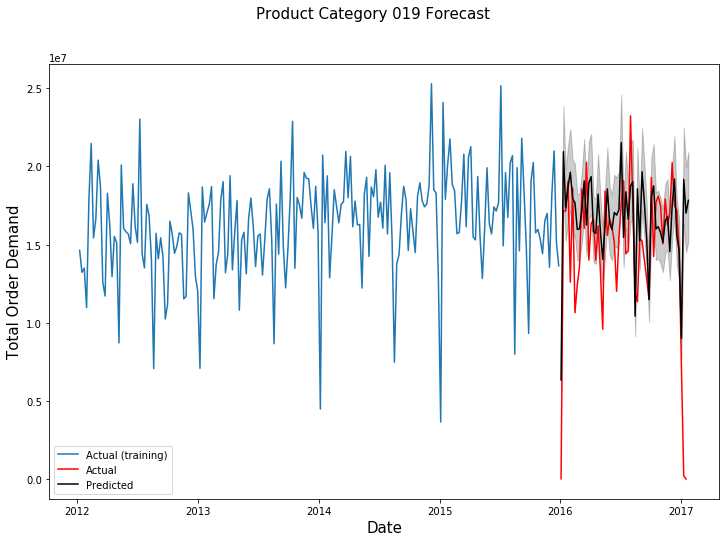

In [46]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)
#date_list = date_index.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
# pred_times2 = pred_ci2.index

# plt.xlim(min(date_list[int(len(date_list) - 24*4) :]), max(pred_times2))
#plt.ylim(min(low_values), max(high_values))

#plt.plot(demand_hat[:1000])
plt.plot(df_0019_weekly.index, df_0019_weekly['Order_Demand'].values, label='Actual (training)')

plt.plot(df_0019_test.index, df_0019_test['Order_Demand'].values, c='r', label='Actual')
plt.plot(pred_vals1.index, pred_vals1.values, c='k', label='Predicted')
plt.legend(loc = "lower left")



plt.fill_between(pred_ci1.index, low_values, high_values, color='k', alpha=0.2)
fig.suptitle('Product Category 019 Forecast', fontsize = 15 )
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Total Order Demand', fontsize = 15);
fig.savefig('ProdCat19FORECAST.jpg')

## Find Mean Absolute Error as Percent

#### Define y_pred  (Predictios) for MAE 

In [47]:
len(pred_vals1)

56

In [48]:
y_pred = pred_vals1[:-1]

In [49]:
len(y_pred)

55

#### Define y_true (Actuals) for MAE 

In [50]:
y_true = df_0019_test.Order_Demand
y_true.head()

Date
2016-01-03       18100.0
2016-01-10    17173666.0
2016-01-17    17153218.0
2016-01-24    19041646.0
2016-01-31    12605974.0
Freq: W-SUN, Name: Order_Demand, dtype: float64

In [51]:
len(y_true)

55

In [52]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(mae)


3126406.331175487


In [53]:
y_true.mean()

14811961.0

In [54]:
#Convert to % so can compare across Product Categories
mae/y_true.mean()*100

21.107308689075584

In [55]:
y_true.std()

4595406.395528401

In [56]:
#Root Mean Squared Error
(((y_pred - y_true)**2).mean())**.5

4634896.990458469